Epoch 1, Gen Loss: 0.8090527653694153, Disc Loss: 1.3689202070236206, Metric Diff: -0.0826231872493326
Epoch 2, Gen Loss: 0.8300390243530273, Disc Loss: 1.267645239830017, Metric Diff: -0.014990228956371449
Epoch 3, Gen Loss: 2.336301803588867, Disc Loss: 0.7106820344924927, Metric Diff: -0.11566090936008092
Epoch 4, Gen Loss: 2.531585216522217, Disc Loss: 0.6401697397232056, Metric Diff: -0.09853297824206941
Epoch 5, Gen Loss: 2.8090732097625732, Disc Loss: 0.6394041180610657, Metric Diff: -0.07622754926028841
Epoch 6, Gen Loss: 2.555168628692627, Disc Loss: 0.7306462526321411, Metric Diff: -0.04369137043300264
Epoch 7, Gen Loss: 1.6868880987167358, Disc Loss: 1.0563974380493164, Metric Diff: -0.02990062887015929
Epoch 8, Gen Loss: 0.8097896575927734, Disc Loss: 1.3747167587280273, Metric Diff: -0.021319914405971696
Epoch 9, Gen Loss: 0.6871551275253296, Disc Loss: 1.4083553552627563, Metric Diff: 0.020185854489177535
Epoch 10, Gen Loss: 0.7097455859184265, Disc Loss: 1.38607764244079

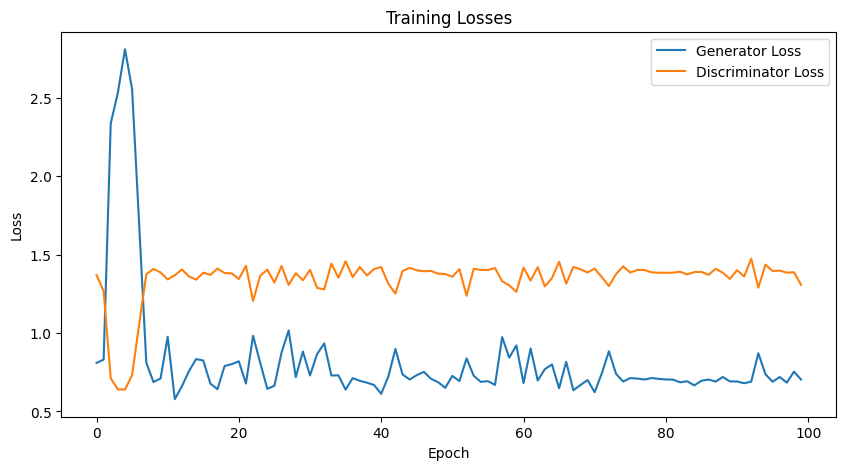

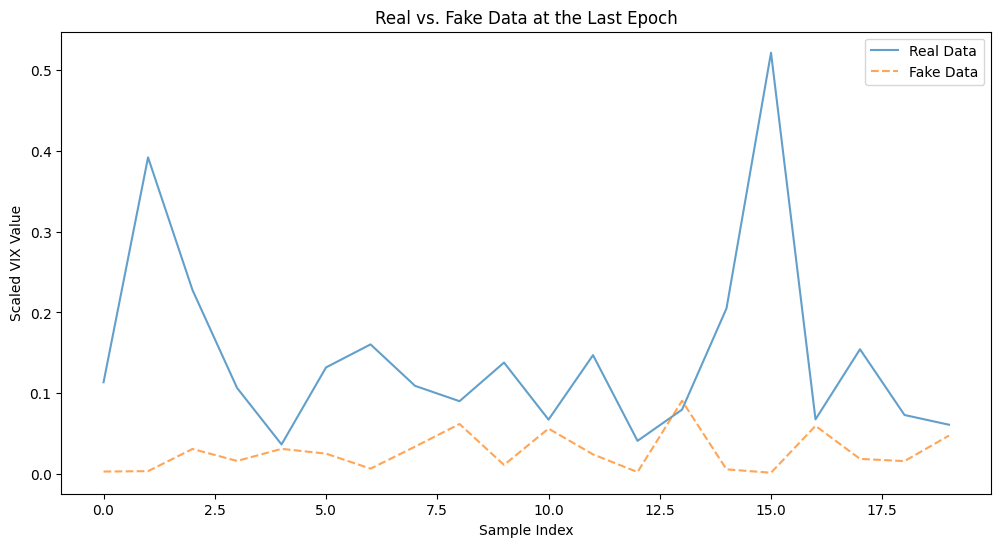

Mean Differences per Epoch: [-0.0826231872493326, -0.014990228956371449, -0.11566090936008092, -0.09853297824206941, -0.07622754926028841, -0.04369137043300264, -0.02990062887015929, -0.021319914405971696, 0.020185854489177535, 0.034547563845485546, -0.18860993141475313, 0.10535748695787794, -0.09491074437442412, -0.0029747074300348064, 0.012406971508830855, -0.017211470549732377, 0.0793692881411017, -0.08051342124286287, -0.06177369112315764, 0.09841395562347777, -0.2509067391807138, 0.1413973720913828, 0.055924844199985335, -0.025582287257343433, 0.0002762342041433552, 0.11915076171812422, -0.1262020205909311, 0.05543025975880034, -0.04358153397384279, -0.016235951131015947, -0.052475843375354936, 0.14688435589727766, -0.11932236308398836, 0.05764348452743895, -0.1682758664542734, 0.12336650138553987, 0.13852304985579855, -0.03702013546767821, -0.20255613679233186, 0.043040108138889144, 0.06655158495363597, -0.2222207223826944, -0.07973188514056795, -0.01049788648429506, 0.0455620700

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load and preprocess data
data_path = 'VIX.csv'
vix_data = pd.read_csv(data_path)
vix_values = vix_data['VIX'].values.reshape(-1, 1)

scaler = MinMaxScaler()
vix_values_scaled = scaler.fit_transform(vix_values)
train_dataset = tf.data.Dataset.from_tensor_slices(vix_values_scaled).shuffle(len(vix_values_scaled)).batch(32)

# Generator and Discriminator Models
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(256, input_shape=(100,), use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dense(512, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dense(1024, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dense(2048, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dense(4096, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Dense(4096, input_shape=(1,)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Dense(2048),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Dense(1024),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Dense(512),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Dense(256),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Dense(1)
    ])
    return model

#loss and optimizer - BCE and adam
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#Training step definition
def train_step(real_data):
    noise = tf.random.normal([32, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)
        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(generated_data, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return real_data, generated_data, gen_loss.numpy(), disc_loss.numpy()

# Training function with loss plotting over a window of 20
def train(dataset, epochs):
    gen_losses = []
    disc_losses = []
    metric_diff = []
    final_mean=[]
    for epoch in range(epochs):
        epoch_gen_losses = []
        epoch_disc_losses = []
        real_samples = []
        fake_samples = []

        for real_data in dataset:
            real_data, generated_data, gen_loss, disc_loss = train_step(real_data)
            real_samples.extend(real_data.numpy())
            fake_samples.extend(generated_data.numpy())
            epoch_gen_losses.append(gen_loss)
            epoch_disc_losses.append(disc_loss)

        gen_losses.append(np.mean(epoch_gen_losses))
        disc_losses.append(np.mean(epoch_disc_losses))
        metric_diff.append(np.mean(real_samples) - np.mean(fake_samples))
        final_mean=np.mean(real_samples) - np.mean(fake_samples)

        print(f"Epoch {epoch+1}, Gen Loss: {gen_losses[-1]}, Disc Loss: {disc_losses[-1]}, Metric Diff: {metric_diff[-1]}")

    # Plotting generator and discriminator losses
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    display_start_index = 0  # Start index of the sample to display
    display_end_index = 20  # End index of the sample to display

    plt.figure(figsize=(12, 6))
    plt.plot(real_samples[display_start_index:display_end_index], label='Real Data', alpha=0.7)
    plt.plot(fake_samples[display_start_index:display_end_index], label='Fake Data', alpha=0.7, linestyle='--')
    plt.title('Real vs. Fake Data at the Last Epoch')
    plt.xlabel('Sample Index')
    plt.ylabel('Scaled VIX Value')
    plt.legend()
    plt.show()


    return metric_diff

# Train the model
metric_difference = train(train_dataset, epochs=100)
print("Mean Differences per Epoch:", metric_difference)


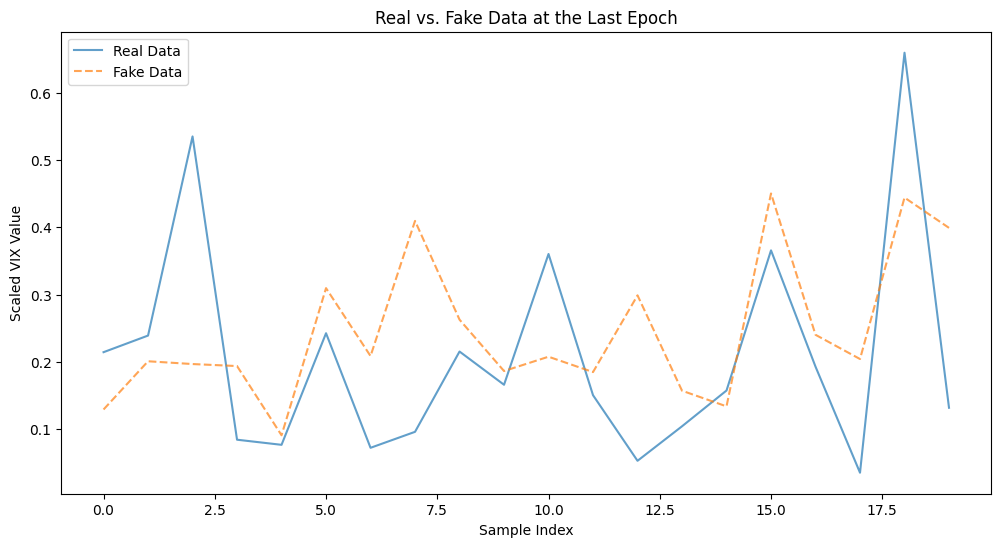

In [ ]:
train(train_dataset, EPOCHS)